In [1]:
pip install torch

In [2]:
pip install pytorch_spiking

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import time
import pytorch_spiking
import torchvision
torch.manual_seed(0)
np.random.seed(0)

100%|██████████| 26421880/26421880 [00:01<00:00, 16029366.40it/s]


Extracting ./FashionMNIST/raw/train-images-idx3-ubyte.gz to ./FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 269610.47it/s]


Extracting ./FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 5045119.47it/s]


Extracting ./FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 15141849.22it/s]


Extracting ./FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./FashionMNIST/raw



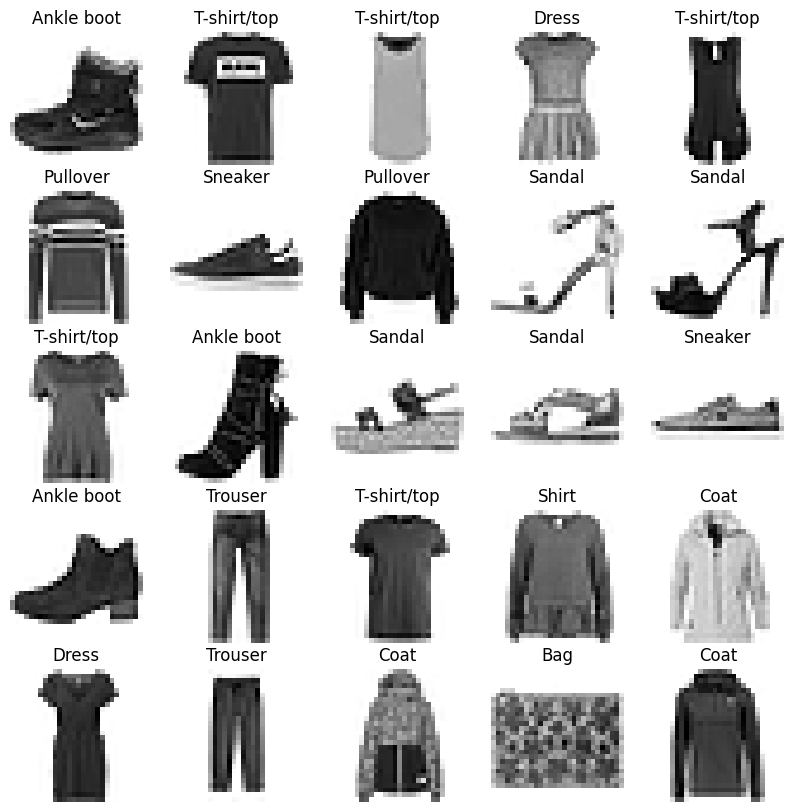

In [4]:
train_pictures, train_labels = zip(
    *torchvision.datasets.FashionMNIST(".", train=True, download=True)
)
train_pictures = np.asarray([np.array(pic) for pic in train_pictures], dtype=np.float32)
train_labels = np.asarray(train_labels, dtype=np.int64)
test_pictures, test_labels = zip(
    *torchvision.datasets.FashionMNIST(".", train=False, download=True)
)
test_pictures = np.asarray([np.array(pic) for pic in train_pictures], dtype=np.float32)
test_labels = np.asarray(train_labels, dtype=np.int64)

# normalize images so values are between 0 and 1
train_pictures = train_pictures / 255.0
test_pictures = test_pictures / 255.0

class_labels = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]
num_classes = len(class_labels)

plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.imshow(train_pictures[i], cmap=plt.cm.binary)
    plt.axis("off")
    plt.title(class_labels[train_labels[i]])

In [20]:
def train(input_ssn, train_x, test_x):
    minibatch_size = 32
    optimizer = torch.optim.Adamax(input_ssn.parameters())
    s = time.time()
    input_ssn.train()
    for j in range(10):
        train_acc = 0
        for i in range(train_x.shape[0] // minibatch_size):
            input_ssn.zero_grad()

            input_batch = train_x[i * minibatch_size : (i + 1) * minibatch_size]
            # flatten images
            input_batch = input_batch.reshape((-1,) + train_x.shape[1:-2] + (784,))
            batch_label = train_labels[i * minibatch_size : (i + 1) * minibatch_size]
            output = input_ssn(torch.tensor(input_batch))

            # compute sparse categorical cross entropy loss
            logp = torch.nn.functional.log_softmax(output, dim=-1)
            logpy = torch.gather(logp, 1, torch.tensor(batch_label).view(-1, 1))
            loss = -logpy.mean()

            loss.backward()#bptt
            optimizer.step()

            train_acc += torch.mean(
                torch.eq(torch.argmax(output, dim=1), torch.tensor(batch_label)).float()
            )

        train_acc /= i + 1
        print(f"Accuracy(Training) ({j}): {train_acc.numpy()}")
    train_time= time.time() - s
    print("Training time:",train_time)
    # compute test accuracy
    s1=time.time()
    input_ssn.eval()
    test_acc = 0
    for i in range(test_x.shape[0] // minibatch_size):
        input_batch = test_x[i * minibatch_size : (i + 1) * minibatch_size]
        input_batch = input_batch.reshape((-1,) + test_x.shape[1:-2] + (784,))
        batch_label = test_labels[i * minibatch_size : (i + 1) * minibatch_size]
        output = input_ssn(torch.tensor(input_batch))

        test_acc += torch.mean(
            torch.eq(torch.argmax(output, dim=1), torch.tensor(batch_label)).float()
        )

    test_acc /= i + 1

    print(f"Accuracy(Testing) {test_acc.numpy()}")
    e=time.time()-s

In [21]:
# repeat the images for n_steps
n_steps = 10
train_stream = np.tile(train_pictures[:, None], (1, n_steps, 1, 1))
test_stream = np.tile(test_pictures[:, None], (1, n_steps, 1, 1))

In [7]:
class SelfAttention(torch.nn.Module):
    def __init__(self, input_dim):
        super(SelfAttention, self).__init__()
        self.query = torch.nn.Linear(input_dim, input_dim)
        self.key = torch.nn.Linear(input_dim, input_dim)
        self.value = torch.nn.Linear(input_dim, input_dim)

    def forward(self, x):
        q = self.query(x)
        k = self.key(x)
        v = self.value(x)
        attn_weights = torch.nn.functional.softmax(q @ k.transpose(-2, -1), dim=-1)
        return attn_weights @ v

In [8]:
spikeaware_model = torch.nn.Sequential(
     torch.nn.Linear(784, 256),   #13 layers
     SelfAttention(256),
     torch.nn.SELU(),
    # set spiking_aware_training and a moderate dt
    pytorch_spiking.SpikingActivation(
        torch.nn.ELU(alpha=1.0), dt=0.5, spiking_aware_training=True #exponential linear unit
    ),
    torch.nn.Linear(256,128),
    SelfAttention(128),
    torch.nn.GELU(),
     torch.nn.Dropout(0.4),
       pytorch_spiking.SpikingActivation(
        torch.nn.ELU(alpha=1.0), dt=0.8, spiking_aware_training=True #exponential linear unit
    ),
    torch.nn.Linear(128,64),
    torch.nn.Dropout(0.4),
    pytorch_spiking.TemporalAvgPool(),
    torch.nn.Linear(64, 10),
)


In [13]:
train(spikeaware_model, train_stream, test_stream)

Accuracy(Training) (0): 0.8568000197410583
Accuracy(Training) (1): 0.864716649055481
Accuracy(Training) (2): 0.8720333576202393
Accuracy(Training) (3): 0.8761666417121887
Accuracy(Training) (4): 0.878849983215332
Accuracy(Training) (5): 0.8823500275611877
Accuracy(Training) (6): 0.8884166479110718
Accuracy(Training) (7): 0.8894333243370056
Accuracy(Training) (8): 0.89246666431427
Accuracy(Training) (9): 0.8946833610534668
Accuracy(Training) (10): 0.8979499936103821
Accuracy(Training) (11): 0.8984000086784363
Accuracy(Training) (12): 0.8999999761581421
Accuracy(Training) (13): 0.9010166525840759
Accuracy(Training) (14): 0.902999997138977
Accuracy(Training) (15): 0.904366672039032
Accuracy(Training) (16): 0.9062833189964294
Accuracy(Training) (17): 0.9081000089645386
Accuracy(Training) (18): 0.9091333150863647
Accuracy(Training) (19): 0.9103500247001648
Accuracy(Training) (20): 0.911466658115387
Accuracy(Training) (21): 0.9107166528701782
Accuracy(Training) (22): 0.9136166572570801
Accur

In [12]:
print(spikeaware_model)

Sequential(
  (0): Linear(in_features=784, out_features=256, bias=True)
  (1): SelfAttention(
    (query): Linear(in_features=256, out_features=256, bias=True)
    (key): Linear(in_features=256, out_features=256, bias=True)
    (value): Linear(in_features=256, out_features=256, bias=True)
  )
  (2): SELU()
  (3): SpikingActivation(
    (activation): ELU(alpha=1.0)
  )
  (4): Linear(in_features=256, out_features=128, bias=True)
  (5): SelfAttention(
    (query): Linear(in_features=128, out_features=128, bias=True)
    (key): Linear(in_features=128, out_features=128, bias=True)
    (value): Linear(in_features=128, out_features=128, bias=True)
  )
  (6): GELU(approximate='none')
  (7): Dropout(p=0.4, inplace=False)
  (8): SpikingActivation(
    (activation): ELU(alpha=1.0)
  )
  (9): Linear(in_features=128, out_features=64, bias=True)
  (10): Dropout(p=0.4, inplace=False)
  (11): TemporalAvgPool()
  (12): Linear(in_features=64, out_features=10, bias=True)
)


In [10]:
import torch
from torchsummary import summary
# Assuming the input size is 784
sample_input = torch.rand((1, 784))  # Adding an extra dimension

# Use torchsummary with the corrected input shape
summary(spikeaware_model, sample_input.shape)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 1, 256]         200,960
            Linear-2               [-1, 1, 256]          65,792
            Linear-3               [-1, 1, 256]          65,792
            Linear-4               [-1, 1, 256]          65,792
     SelfAttention-5               [-1, 1, 256]               0
              SELU-6               [-1, 1, 256]               0
               ELU-7               [-1, 1, 256]               0
 SpikingActivation-8               [-1, 1, 256]               0
            Linear-9               [-1, 1, 128]          32,896
           Linear-10               [-1, 1, 128]          16,512
           Linear-11               [-1, 1, 128]          16,512
           Linear-12               [-1, 1, 128]          16,512
    SelfAttention-13               [-1, 1, 128]               0
             GELU-14               [-1,

In [22]:
def check_output(seq_model, modify_dt=None):
    # rebuild the model in a form that will let us access the output of
    # intermediate layers
    class Model(torch.nn.Module):
        def __init__(self):
            super().__init__()

            self.has_temporal_pooling = False
            for i, module in enumerate(seq_model.modules()):
                if isinstance(module, pytorch_spiking.TemporalAvgPool):
                    # remove the pooling so that we can see the model's output over time
                    self.has_temporal_pooling = True
                    continue

                if isinstance(
                    module, (pytorch_spiking.SpikingActivation, pytorch_spiking.Lowpass)
                ):
                    # update dt, if specified
                    if modify_dt is not None:
                        module.dt = modify_dt
                    # always return the full time series so we can visualize it
                    module.return_sequences = True

                if isinstance(module, pytorch_spiking.SpikingActivation):
                    # save this layer so we can access it later
                    self.spike_layer = module

                if i > 0:
                    self.add_module(str(i), module)

        def forward(self, inputs):
            x = inputs

            for i, module in enumerate(self.modules()):
                if i > 0:
                    x = module(x)

                    if isinstance(module, pytorch_spiking.SpikingActivation):
                        # save this layer so we can access it later
                        spike_output = x

            return x, spike_output

    func_model = Model()

    # run model
    func_model.eval()
    with torch.no_grad():
        output, spikes = func_model(
            torch.tensor(
                test_stream.reshape(
                    test_stream.shape[0], test_stream.shape[1], -1
                )
            )
        )
    output = output.numpy()
    spikes = spikes.numpy()

    if func_model.has_temporal_pooling:
        # check test accuracy using average output over all timesteps
        predictions = np.argmax(output.mean(axis=1), axis=-1)
    else:
        # check test accuracy using output from last timestep
        predictions = np.argmax(output[:, -1], axis=-1)
    accuracy = np.equal(predictions, test_labels).mean()


    time = test_stream.shape[1] * func_model.spike_layer.dt
    n_spikes = spikes * func_model.spike_layer.dt
    rates = np.sum(n_spikes, axis=1) / time

    print(
        f"Spike rate per neuron (Hz): "
        f"min={np.min(rates):.2f} mean={np.mean(rates):.2f} max={np.max(rates):.2f}"
    )

    # plot output
    for ii in range(4):
        plt.figure(figsize=(12, 4))

        plt.subplot(1, 3, 1)
        plt.title(class_labels[test_labels[ii]])
        plt.imshow(test_pictures[ii], cmap="gray")
        plt.axis("off")

        plt.subplot(1, 3, 2)
        plt.title("Spikes per neuron per timestep")
        bin_edges = np.arange(int(np.max(n_spikes[ii])) + 2) - 0.5
        plt.hist(np.ravel(n_spikes[ii]), bins=bin_edges)
        x_ticks = plt.xticks()[0]
        plt.xticks(
            x_ticks[(np.abs(x_ticks - np.round(x_ticks)) < 1e-8) & (x_ticks > -1e-8)]
        )
        plt.xlabel("# of spikes")
        plt.ylabel("Frequency")

        plt.subplot(1, 3, 3)
        plt.title("Output predictions")
        plt.plot(
            np.arange(test_stream.shape[1]) * func_model.spike_layer.dt,
            torch.softmax(torch.tensor(output[ii]), dim=-1),
        )
        plt.legend(class_labels, loc="upper left")
        plt.xlabel("Time (s)")
        plt.ylabel("Probability")
        plt.ylim([-0.05, 1.05])

        plt.tight_layout()

Spike rate per neuron (Hz): min=0.00 mean=3.50 max=50.00


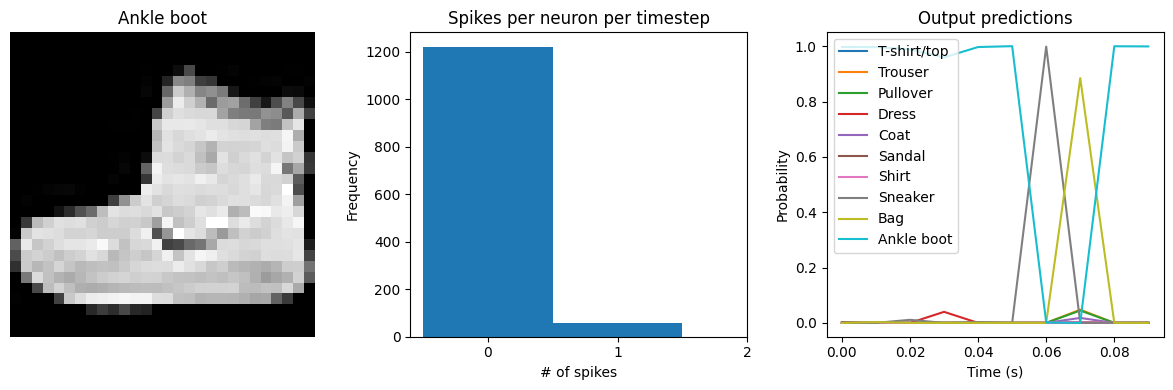

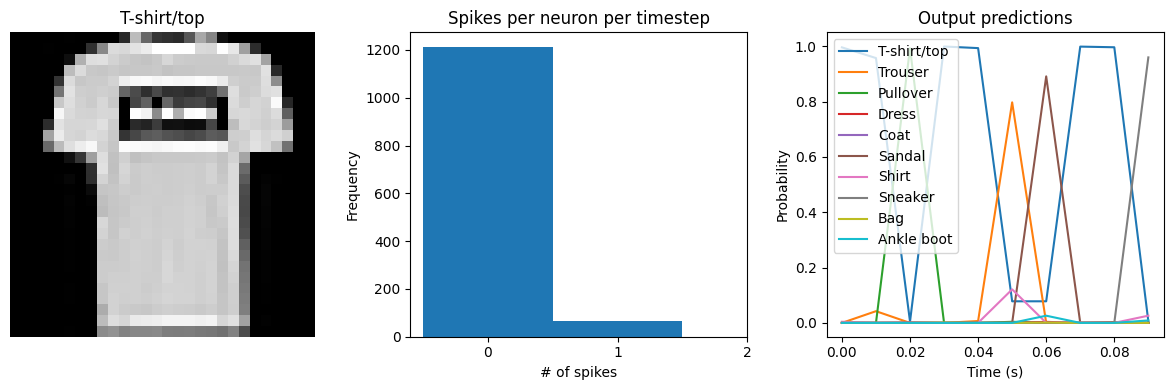

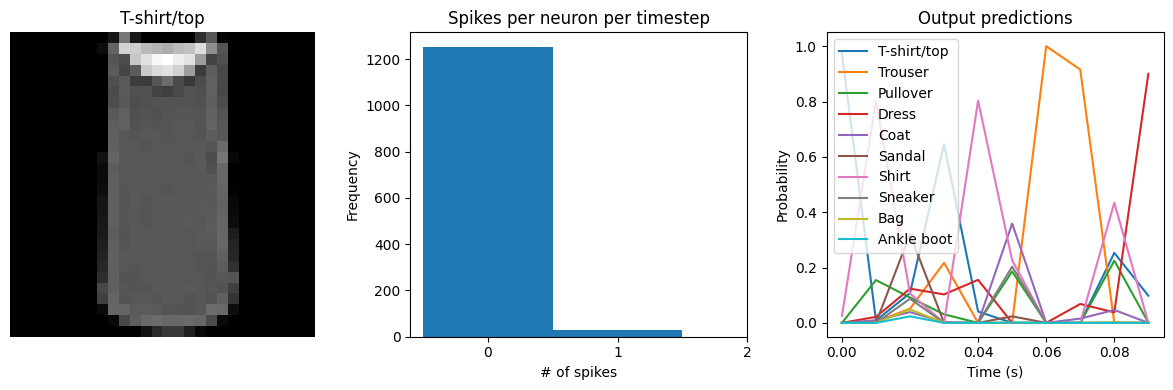

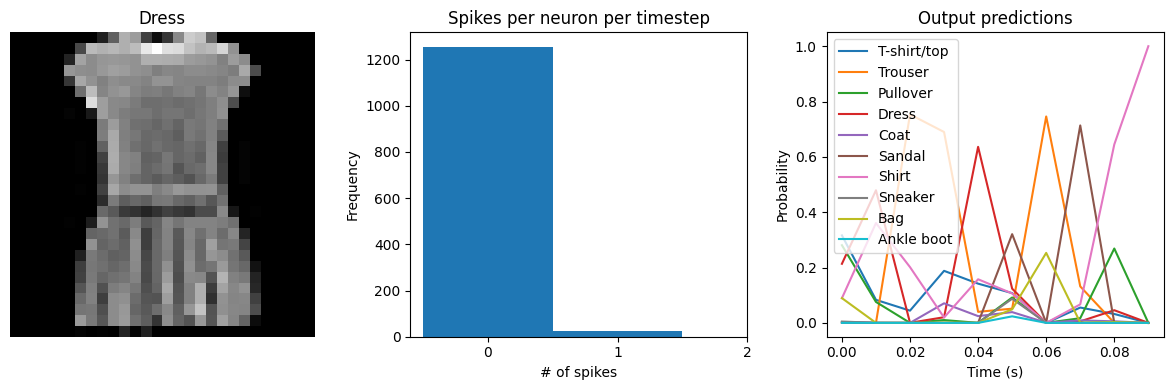

In [24]:
check_output(spikeaware_model)